## Github Repo
https://github.com/854740262/stock_prediction

## Team Member
Le Qin

## Stock prices analysis  
In this project, we will try to analysis time series data on Google stock prices from 2010 to 2016.  
Specificly, we want to estimate the last 10 day of the dataset using other data as training set.  
Data from https://www.kaggle.com/dgawlik/nyse.  

## Libray import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import scale
from sklearn.linear_model import LinearRegression, Lasso
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
%matplotlib inline

## Data cleaning

In [2]:
priceDF = pd.read_csv('prices-split-adjusted.csv', index_col=0)
priceDF.head()

,symbol,open,close,low,high,volume
date,,,,,,
2016-01-05,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
2016-01-06,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2016-01-07,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
2016-01-08,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
2016-01-11,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0


In [3]:
priceDF.isnull().any()

symbol    False
open      False
close     False
low       False
high      False
volume    False
dtype: bool

In [4]:
priceDF.dtypes

symbol     object
open      float64
close     float64
low       float64
high      float64
volume    float64
dtype: object

Data is already cleaned. Missing values were dropped due to weekends or company special event.

#### In this project, we will only use data from Google.

In [5]:
gDF = priceDF[priceDF['symbol'] == 'GOOGL']
gDF.drop(['symbol'], axis=1, inplace=True)


/dst1_env/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


## Data Summary

In [6]:
gDF.head()

,open,close,low,high,volume
date,,,,,
2010-01-04,313.788792,313.688694,312.432438,315.070073,3908400.0
2010-01-05,313.903904,312.307316,311.081089,314.234226,6003300.0
2010-01-06,313.243260,304.434452,303.483494,313.243260,7949400.0
2010-01-07,305.005009,297.347355,296.621617,305.305302,12815700.0
2010-01-08,296.296299,301.311314,294.849857,301.926945,9439100.0


In [7]:
gDF.describe()

,open,close,low,high,volume
count,1762.000000,1762.000000,1762.000000,1762.000000,1.762000e+03
mean,467.296599,467.088977,463.037583,471.042921,4.096043e+06
std,181.343840,181.223168,179.767145,182.608562,2.884423e+06
min,219.374377,218.253253,217.032031,221.361361,5.206000e+05
25%,299.672184,299.807316,297.302311,302.253514,2.004075e+06
50%,438.628637,438.786291,436.166174,440.785803,3.670550e+06
75%,587.770005,587.598039,583.287491,591.472856,5.171750e+06
max,838.500000,835.739990,829.039978,839.000000,2.961990e+07


We found that the 4 prices are highly correlated to each other, according to their quantile values, mean and std.  

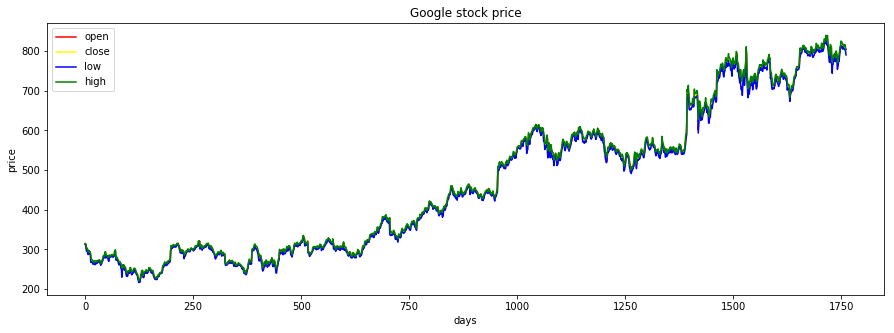

In [8]:
plt.figure(figsize=(15, 5))
plt.plot(gDF.open.values, color='red', label='open')
plt.plot(gDF.close.values, color='yellow', label='close')
plt.plot(gDF.low.values, color='blue', label='low')
plt.plot(gDF.high.values, color='green', label='high')
plt.title('Google stock price')
plt.xlabel('days')
plt.ylabel('price')
plt.legend()

The above graph plots 4 prices from open, close, low , high together of 6 years(2010-2016).  
From the long run, the 4 prices, shows high correlation with each other.

Text(0, 0.5, 'volume')

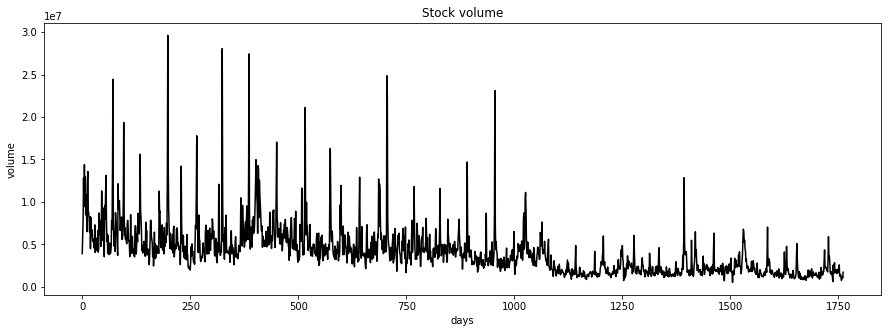

In [9]:
plt.figure(figsize=(15, 5))
plt.plot(gDF.volume.values, color='black')
plt.title('Stock volume')
plt.xlabel('days')
plt.ylabel('volume')

The above graph shows the volumne of transaction per day.  
From the graph, we can see multiple spikes indicating high transaction volumne at that day.  
For both graph, outliers are not dropped due to the nature of the dataset, as they are actual values.

## Method 1: Simple Linear Regression

Since time series data is influenced by previous(more recent) data, we design an experiment by shift the "close" price back for 10 days as acutal data in 10 days, and see if a simple lasso linear regression using open, close, low, high and volumne, 5 predictors can have a good prediction.

In [10]:
slrDF = gDF.copy()
num = 10 
slrDF['actual'] = slrDF['close'].shift(-num) 
slrDF.tail(15)

,open,close,low,high,volume,actual
date,,,,,,
2016-12-09,799.299988,809.450012,798.049988,809.950012,1894000.0,807.799988
2016-12-12,804.820007,807.900024,804.530029,811.349976,1627300.0,809.929993
2016-12-13,812.390015,815.340027,811.940002,824.299988,2103300.0,804.570007
2016-12-14,815.919983,817.890015,812.780029,824.260010,1769700.0,802.880005
2016-12-15,817.359985,815.650024,812.000000,823.000000,1768500.0,792.450012
2016-12-16,818.309998,809.840027,808.119995,819.200012,2589100.0,NaN
2016-12-19,809.280029,812.500000,804.500000,816.219971,1259600.0,NaN
2016-12-20,813.369995,815.200012,811.000000,816.489990,1270200.0,NaN
2016-12-21,815.719971,812.200012,805.099976,815.719971,1454500.0,NaN


In [11]:
slrDF.dropna(inplace=True)
slrDF.shape

(1752, 6)

Shape of Full data set

In [12]:
full_X = scale(slrDF.drop(['actual'], axis=1))
full_y = slrDF['actual']
full_X.shape, full_y.shape

((1752, 5), (1752,))

In [13]:
test_X = full_X[-10:]
test_y = full_y[-10:]
test_X.shape, test_y.shape

((10, 5), (10,))

In [14]:
train_X = full_X[:-10]
train_y = full_y[:-10]
train_X.shape, train_y.shape

((1742, 5), (1742,))

Lasso regression has only one hyperparameter, the alpha value, which controls how strong we restrain the model to prevent overfitting.  

In [15]:
lasso = Lasso(random_state=0)
alphas = np.logspace(-4, -0.5, 30)
tuned_parameters = [{'alpha': alphas}]
clf = GridSearchCV(lasso, tuned_parameters, cv=5)
clf.fit(train_X, train_y)

/dst1_env/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/dst1_env/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/dst1_env/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/dst1_env/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of ite

/dst1_env/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/dst1_env/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/dst1_env/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/dst1_env/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of ite

/dst1_env/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/dst1_env/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/dst1_env/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/dst1_env/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of ite

/dst1_env/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/dst1_env/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/dst1_env/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/dst1_env/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of ite

/dst1_env/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/dst1_env/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/dst1_env/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/dst1_env/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of ite

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=0,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'alpha': array([1.00000e-04, 1.32035e-04, 1.74333e-04, 2.30181e-04, 3.03920e-04,
       4.01281e-04, 5.29832e-04, 6.99564e-04, 9.23671e-04, 1.21957e-03,
       1.61026e-03, 2.12611e-03, 2.80722e-03, 3.70651e-03, 4.89390e-03,
       6.46167e-03, 8.53168e-03, 1.12648e-02, 1.48735e-02, 1.96383e-02,
       2.59294e-02, 3.42360e-02, 4.52035e-02, 5.96846e-02, 7.88046e-02,
       1.04050e-01, 1.37382e-01, 1.81393e-01, 2.39503e-01, 3.16228e-01])}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [16]:
clf.score(train_X, train_y)

0.9845008394201962

$r^2$ for training set is above 0.98, may indicating strong overfitting

In [17]:
train_predict = clf.predict(train_X)
residual = train_predict - train_y
np.mean(np.square(residual))

501.7568358576729

The fitted value plot is too close to the actual plot, showing residual plot instead. 

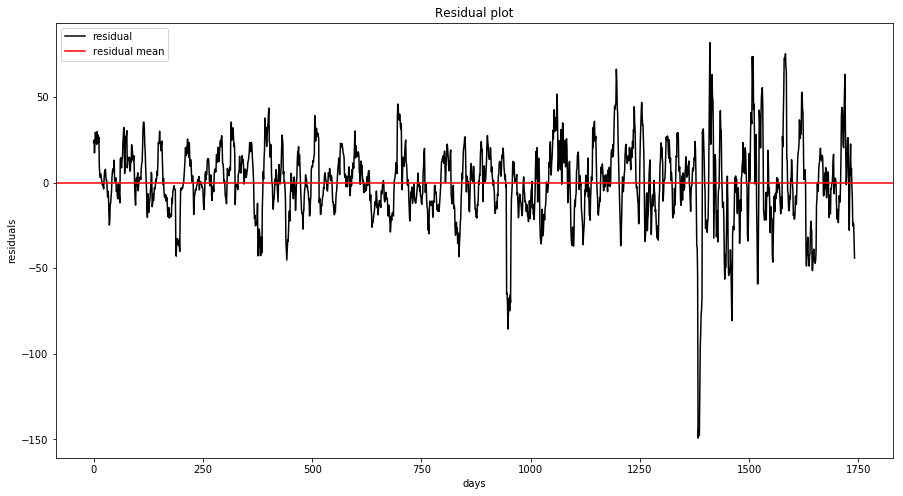

In [18]:
plt.figure(figsize=(15,8))
plt.plot(residual.values, color='black', label='residual')
plt.axhline(np.mean(residual), color='red', label='residual mean')
plt.title('Residual plot')
plt.xlabel('days')
plt.ylabel('residuals')
plt.legend()

In [19]:
forecast = clf.predict(test_X)
Predict_df = pd.DataFrame(test_y)
Predict_df['predict'] = forecast
Predict_df

,actual,predict
date,,
2016-12-02,809.840027,765.836783
2016-12-05,812.500000,777.293919
2016-12-06,815.200012,780.029506
2016-12-07,812.200012,788.941011
2016-12-08,809.679993,796.532437
2016-12-09,807.799988,807.421103
2016-12-12,809.929993,808.828574
2016-12-13,804.570007,815.955605
2016-12-14,802.880005,819.093322


Note: since we shift back 10 days, the result is actual predicting the last 10 days in the dataset.

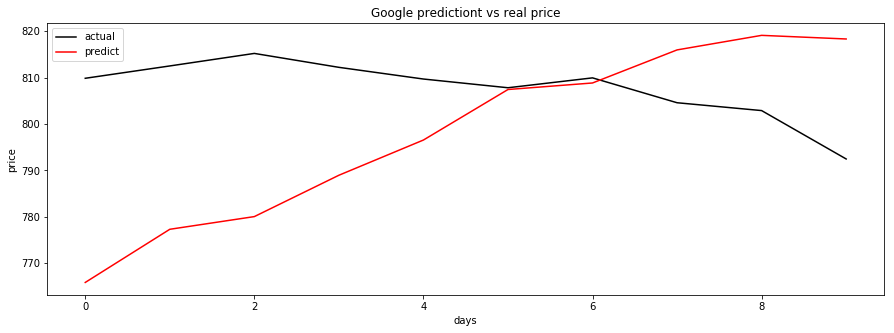

In [20]:
plt.figure(figsize=(15, 5))
plt.plot(Predict_df.actual.values, color='black', label='actual')
plt.plot(Predict_df.predict.values, color='red', label='predict')
plt.title('Google predictiont vs real price')
plt.xlabel('days')
plt.ylabel('price')
plt.legend()

By the look of the prediction, the experiment failed.  
Maybe just using todays value to predict exactly 10 days later is not eough.

## Method 2: ARIMA

$X_t-\alpha_1X_{t-1}-...-\alpha_pX_{t-p} = \epsilon_t+\theta_1\epsilon_{t-1}+...+\theta_q\epsilon_{t-q}$  
The left side is autoregressive, the current value minus some value times 1 day before minus some value times 2 day before....  
This gives the error that is described by the moving average on the right.  
ARIMA also reuqire stationary, a one-day difference can do the job.  
Dickey-Fuller test is a way to test stationary

In [21]:
arimaDF=gDF.copy()
arimaDF.index = pd.to_datetime(arimaDF.index, format="%Y/%m/%d")
arimaDF_close = pd.Series(arimaDF['close'])

/dst1_env/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


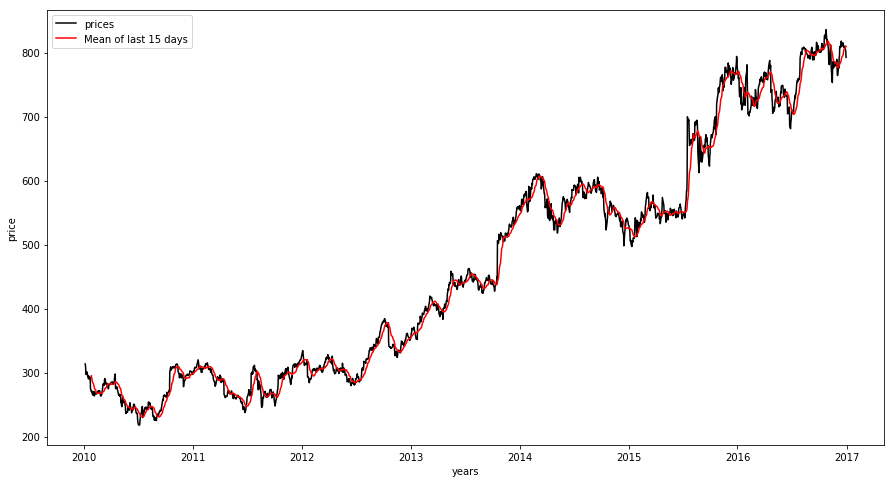

In [22]:
roll_mean = arimaDF_close.rolling(15).mean()

fig = plt.figure(figsize=(15,8))
plt.plot(arimaDF_close, color='black', label='prices')
plt.plot(roll_mean, color='red', label='Mean of last 15 days')
plt.xlabel('years')
plt.ylabel('price')
plt.legend()

In [23]:
print('Dickey-Fuller test')
pvalue = adfuller(arimaDF_close, regresults=False)[1]
print('pvalue:',pvalue)

Dickey-Fuller test
pvalue: 0.9461691091878139


With large pvalue, the data is more likely to be non-stationary

In [24]:
arimaDF_close_diff = arimaDF_close - arimaDF_close.shift()
arimaDF_close_diff.dropna(inplace=True)

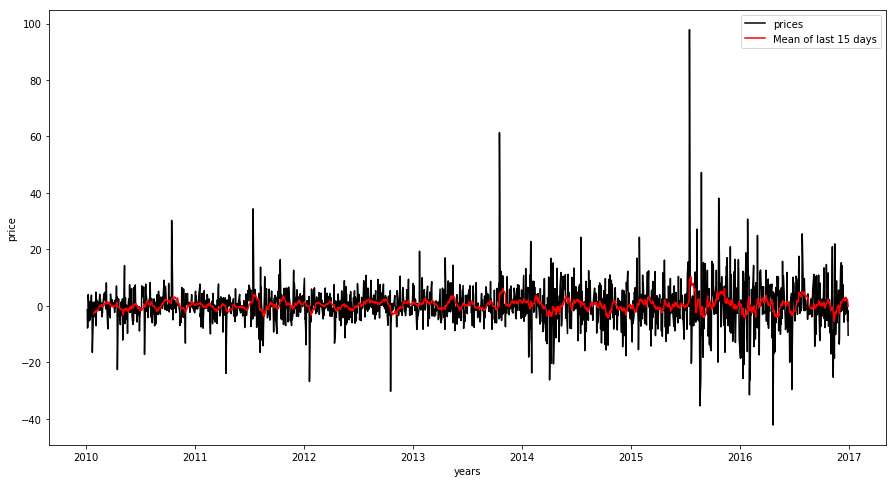

In [25]:
roll_mean = arimaDF_close_diff.rolling(15).mean()

fig = plt.figure(figsize=(15,8))
plt.plot(arimaDF_close_diff, color='black', label='prices')
plt.plot(roll_mean, color='red', label='Mean of last 15 days')
plt.xlabel('years')
plt.ylabel('price')
plt.legend()

In [26]:
print('Dickey-Fuller test')
pvalue = adfuller(arimaDF_close_diff, regresults=False)[1]
print('pvalue:',pvalue)

Dickey-Fuller test
pvalue: 0.0


With a small pvalue, we can reject the null hypothesis. Proceed to ARIMA

ARIMA has three hyperparameter p, d, and q. Where as:
p is the number of lag observations in the model.  
d is the number of times that the raw observations are differenced.  
q is the size of the moving average window.  
MSE is used to select the best hyperparameter since it is composite of both Bias and Variance.

### The following grid serach Cross Validation code are referenced from https://machinelearningmastery.com/grid-search-arima-hyperparameters-with-python/, "How to Grid Search ARIMA Model Hyperparameters with Python".  
### Warning: long running time (can skip)

In [27]:
import warnings
from pandas import Series
from sklearn.metrics import mean_squared_error

In [28]:
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    return error

In [29]:
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

In [31]:
p_values = [0, 1, 2]
d_values = range(0, 2)
q_values = range(0, 2)
warnings.filterwarnings("ignore")
evaluate_models(arimaDF_close_diff.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=98.669
ARIMA(0, 0, 1) MSE=98.803
ARIMA(0, 1, 0) MSE=183.706
ARIMA(0, 1, 1) MSE=98.927
ARIMA(1, 0, 0) MSE=98.805
ARIMA(1, 1, 0) MSE=144.196
Best ARIMA(0, 0, 0) MSE=98.669


### The above grid serach Cross Validation code are referenced from https://machinelearningmastery.com/grid-search-arima-hyperparameters-with-python/, "How to Grid Search ARIMA Model Hyperparameters with Python".

In [32]:
arima = ARIMA(arimaDF_close_diff, (1,1,0))
fitted_model = arima.fit()

However, the fitted values are differences from the previous one. Recovering by using cumulative sum, then add back to original data.

In [33]:
pred=arimaDF_close.add(fitted_model.fittedvalues.cumsum(), fill_value=0)

In [34]:
pred_df = pd.DataFrame(arimaDF_close[-10:])
pred_df['predict'] = pred[-10:]
pred_df

,close,predict
date,,
2016-12-16,809.840027,804.245161
2016-12-19,812.500000,808.637451
2016-12-20,815.200012,807.215895
2016-12-21,812.200012,804.192994
2016-12-22,809.679993,804.440909
2016-12-23,807.799988,802.324101
2016-12-27,809.929993,804.139494
2016-12-28,804.570007,796.826391
2016-12-29,802.880005,798.774618


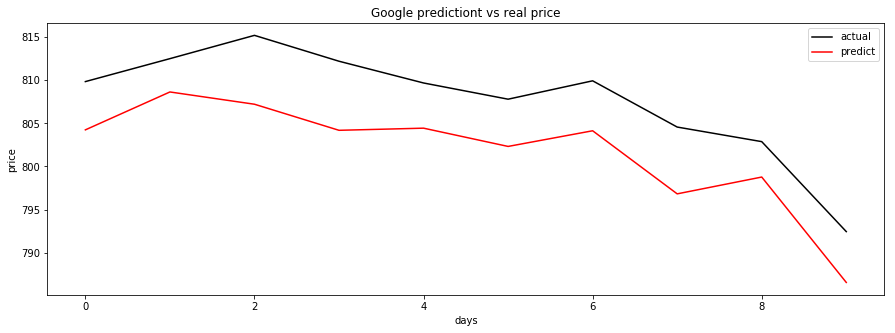

In [35]:
plt.figure(figsize=(15, 5))
plt.plot(pred_df.close.values, color='black', label='actual')
plt.plot(pred_df.predict.values, color='red', label='predict')
plt.title('Google predictiont vs real price')
plt.xlabel('days')
plt.ylabel('price')
plt.legend()

## References:


- How To Identify Patterns in Time Series Data: Time Series Analysis  
    http://www.statsoft.com/Textbook/Time-Series-Analysis  
- NYSE Stock Data - ARIMA Mode  
    https://www.kaggle.com/ravishankars/nyse-stock-data-arima-model#ARIMA-model-for-NYSE-stock-data
- How to Grid Search ARIMA Model Hyperparameters with Python  
    https://machinelearningmastery.com/grid-search-arima-hyperparameters-with-python/
- Time Series Nested Cross-Validation  
    https://towardsdatascience.com/time-series-nested-cross-validation-76adba623eb9

